In [11]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [4]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset from directory
data_dir = "./Incidents-subset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into training & validation sets
train_size = int(0.8 * len(dataset))  # 80% training
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders for training & validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = dataset.classes
print("Classes:", class_names)


Classes: ['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']


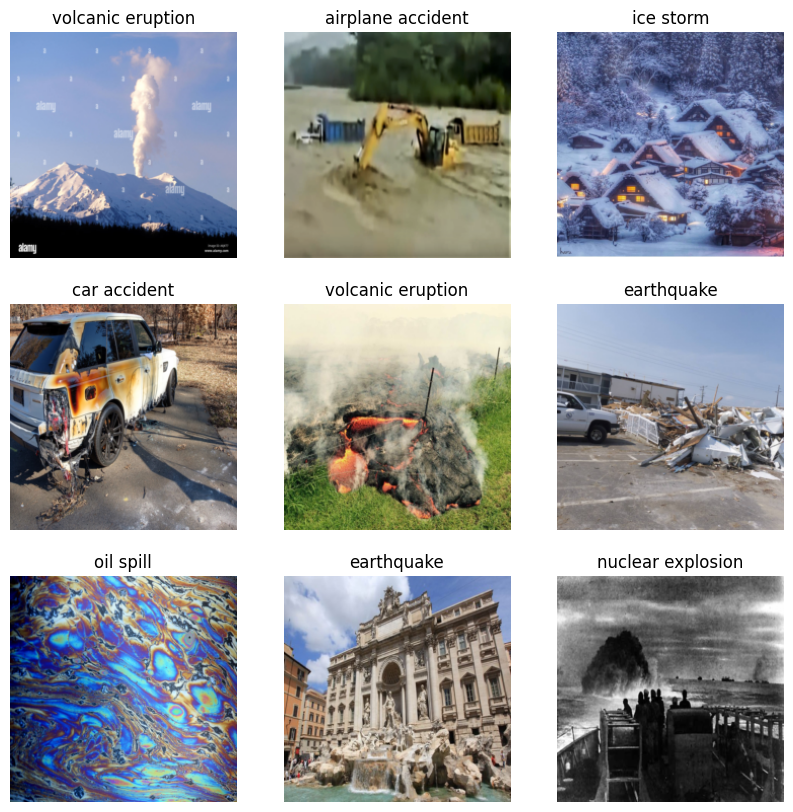

In [ ]:
# Function to denormalize images (optional, if you've normalized them)
def denormalize(image):
    image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    image = image * 0.5 + 0.5  # Reverse normalization (assuming mean=0.5, std=0.5)
    return np.clip(image, 0, 1)  # Ensure pixel values are between 0 and 1

# Get a batch of images from the DataLoader
images, labels = next(iter(train_loader))

# Convert tensor to NumPy and denormalize
images = images[:9]  # Select the first 9 images for visualization
labels = labels[:9]  # Select corresponding labels

# Create a figure
plt.figure(figsize=(10, 10))

for i in range(len(images)):
    ax = plt.subplot(3, 3, i + 1)  # 3x3 grid
    plt.imshow(denormalize(images[i]))  # Convert tensor image to displayable format
    plt.title(class_names[labels[i]])  # Get the class name
    plt.axis("off")

plt.show()


In [15]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Load a pretrained ResNet18 model
model = models.resnet18()

# Freeze the base layers (optional)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer with one matching your number of classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Only training the final layer


# training loop
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(loader), accuracy

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return running_loss / len(loader), accuracy

num_epochs = 5  # For a quick baseline

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")


Device: cpu


/home/kol/Data science/Data-Science-2A/.venv/lib/python3.12/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='./Incidents-subset/airplane accident/.hashed.6f95947e.desktop.story.share.jpg'>